# Part 1: Background removal and differential expression analysis for NanostringWTA data of 19pcw fetal brains with isctools
In this notebook we show how to use the probabilistic generative model in the isctools package for background estimation and differential expression analysis for NanostringWTA data.

Initialize path to this github repository:

In [1]:
import sys,os
path = '/nfs/team283/aa16/InSituCellTools/'
os.chdir(path)
sys.path.append(path)

Load the required modules and configure theano settings:

In [2]:
import pickle
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import diffxpy.api as de
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
from isctools.ProbeCounts__GeneralModel_V1 import ProbeCounts_GeneralModel_V1
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


Load data from our NanostringWTA run:

In [3]:
adata_wta = pickle.load(open(path + "data/nanostringWTA_fetailBrain_AnnData.p", "rb" ))

In this NanostringWTA run we profiled two 19pcw fetal brain cases (one of them with two sections as technical replicates), as well as one 14pcw case. We focussed on the cortex and arranged our ROIs to track neuronal differentiation trajectories from the ventricles on the inside to the cortical plate on the outside of the brain. We call this inside to outside dimension cortical depth. We used both large ROIs as shown in the image below:

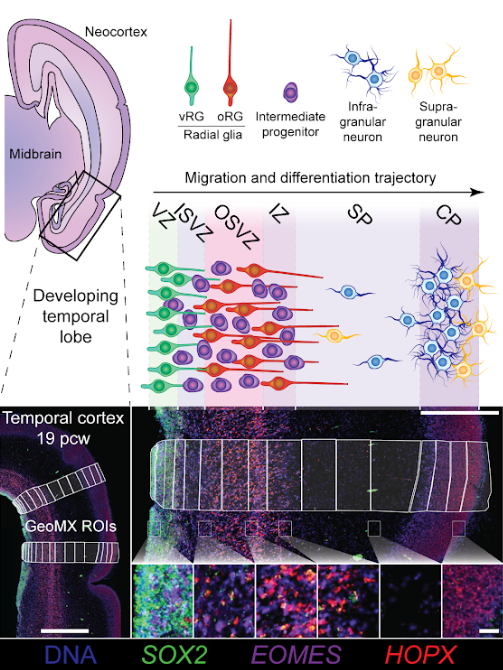

In [4]:
Image(filename='images/GeometricROIs.PNG')

As well as cell type specific areas of interest (AOIs) as shown in this image:

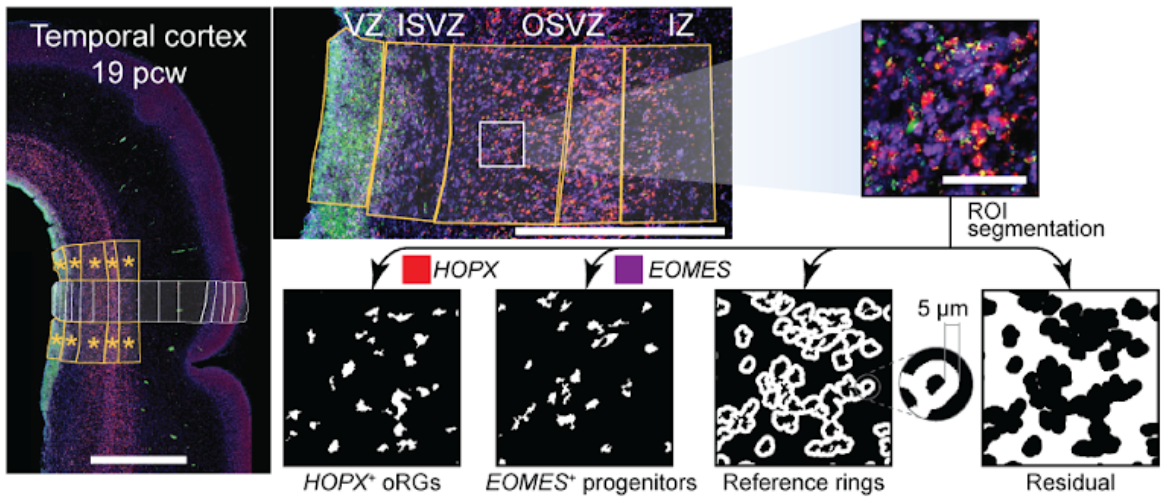

In [5]:
Image(filename='images/CellTypeSpecificAOIs.PNG')

We have already annotated ROIs/AOIs as good or low quality based on a read per nuclei count above 2000 and we do not use low quality ROIs/AOIs in the analysis here:

In [6]:
adata_wta = adata_wta[adata_wta.obs['GoodQuality'],:]

This histogram shows the range of nuclei counts we have in our ROIs/AOIs:

Text(0.5, 1.0, 'Number of Nuclei in ROIs')

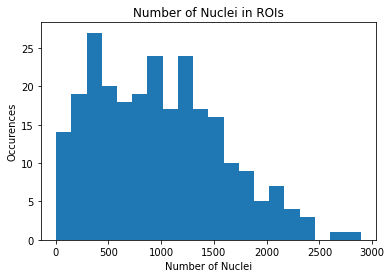

In [7]:
counts_nuclei = np.asarray(adata_wta.obs['nuclei']).reshape(len(adata_wta.obs['nuclei']),1)
plt.hist(counts_nuclei, bins = 20)
plt.xlabel('Number of Nuclei')
plt.ylabel('Occurences')
plt.title('Number of Nuclei in ROIs')

We took those ROIs at different positions across the temporal cortex (cortical depth), with a focus on the ventricular and subventricular zone at low cortical depth, where we also collected cell type specific areas of interest:

Text(0.5, 1.0, 'Number of ROIs at different Cortical Depth')

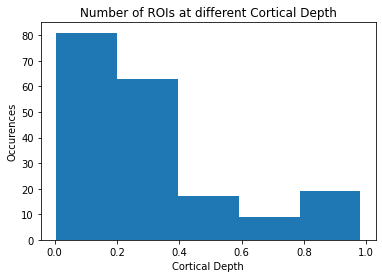

In [8]:
plt.hist(adata_wta.obs['VCDepth'], bins = 5)
plt.xlabel('Cortical Depth')
plt.ylabel('Occurences')
plt.title('Number of ROIs at different Cortical Depth')

The majority of our ROIs/AOIs comes from two 19pcw cases, but we also have a 14pcw case:

Text(0.5, 1.0, 'Number of ROIs per Gestational Age')

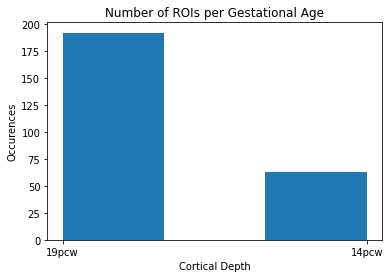

In [9]:
plt.hist(adata_wta.obs['age'], bins = 3)
plt.xlabel('Cortical Depth')
plt.ylabel('Occurences')
plt.title('Number of ROIs per Gestational Age')

There is currently no good way to account for batch effects in our model. Hence, we recommend fitting seperate models to seperate batches. In this analysis we only consider one 19pcw section:

In [10]:
adata_wta = adata_wta[[adata_wta.obs['slide'][i] in ('00MU') for i in range(len(adata_wta.obs['slide']))]]
np.shape(adata_wta)

(74, 18454)

The generative model that we use for NanostringWTA data, decomposes the counts for each gene probe into two parts: one that corresponds to real expression and one that corresponds to measurement noise, which in NanostringWTA data is non-specific binding of probes and sampling noise. To further constrain the real expression, we project it into a low dimensional space of by default 30 positive components (the number of components can be changed, but we have not found a large effect on performance, unless the number is very small. i.e. below 10). A simple summary of the model, showing all parameters and for some parameters also their prior distributions is shown below. Going through this in detail is not necessary for understanding the rest of the notebook and is just shown here for completeness.

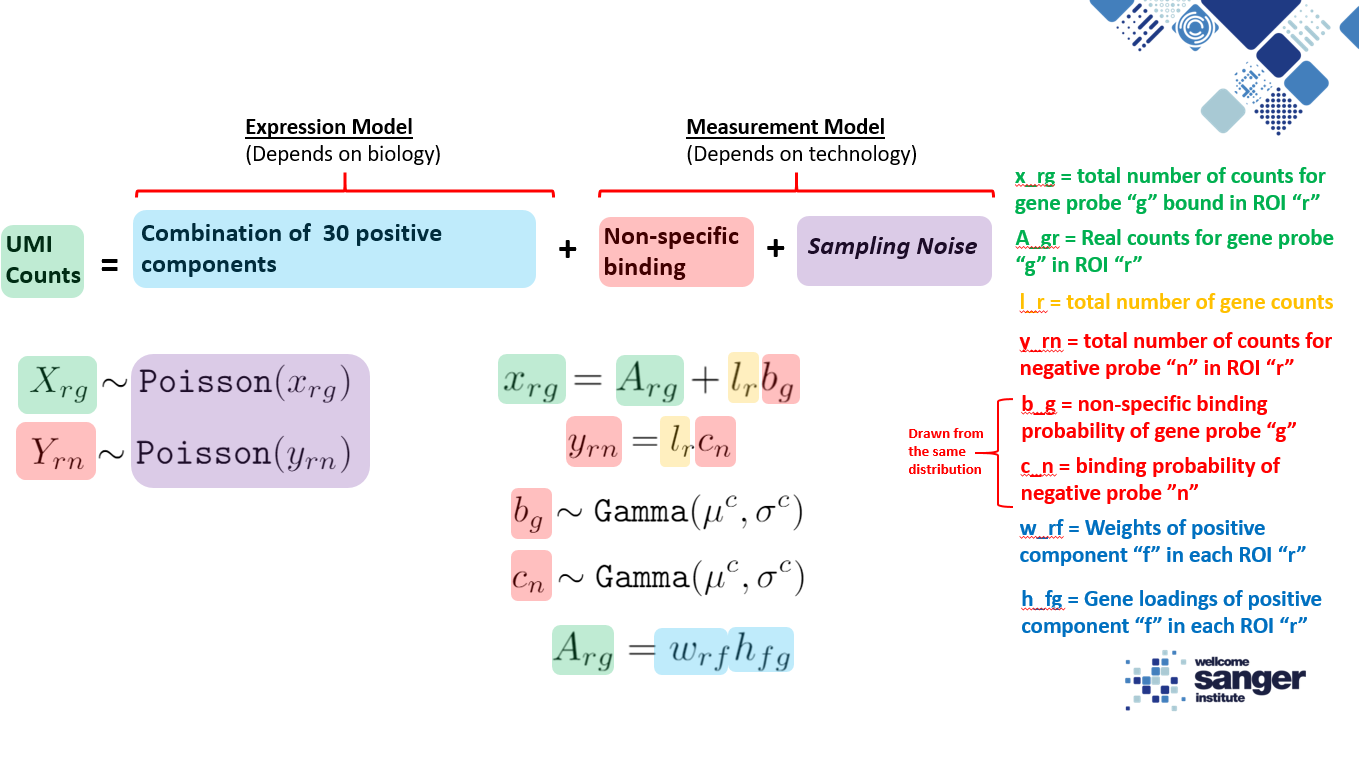

In [11]:
Image(filename='images/ProbeCounts_GeneralModel_V1.PNG')

The model needs seperate gene probes and negative probes in two numpy arrays. We initialize them here:

In [12]:
counts_geneProbes = np.asarray(adata_wta[:,np.array(adata_wta.var != 'NegProbe-WTX').squeeze()].X)
counts_negativeProbes = np.asarray(adata_wta[:,np.array(adata_wta.var == 'NegProbe-WTX').squeeze()].X)

Now we define the model:

In [13]:
mod1 = ProbeCounts_GeneralModel_V1(
        X_data = counts_geneProbes,
        Y_data = counts_negativeProbes,
        var_names = adata_wta.var_names[adata_wta.var_names != 'NegProbe-WTX'],
        n_factors = 30)

And fit the model to our data using automatic differentiation variational inference (advi):

Average Loss = 5.4994e+06: 100%|██████████| 95000/95000 [12:29<00:00, 126.67it/s]
Finished [100%]: Average Loss = 5.4994e+06


Average Loss = 5.4985e+06: 100%|██████████| 1000/1000 [00:08<00:00, 124.00it/s]
Finished [100%]: Average Loss = 5.4985e+06


Average Loss = 5.4987e+06: 100%|██████████| 1000/1000 [00:08<00:00, 124.21it/s]
Finished [100%]: Average Loss = 5.4987e+06


Average Loss = 5.4981e+06: 100%|██████████| 1000/1000 [00:08<00:00, 124.81it/s]
Finished [100%]: Average Loss = 5.4981e+06


Average Loss = 5.4981e+06: 100%|██████████| 1000/1000 [00:08<00:00, 124.53it/s]
Finished [100%]: Average Loss = 5.4981e+06


Average Loss = 5.4996e+06: 100%|██████████| 1000/1000 [00:08<00:00, 124.73it/s]
Finished [100%]: Average Loss = 5.4996e+06


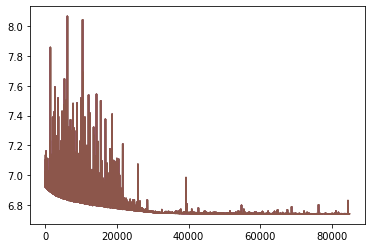

In [14]:
total_iterations = 10**5
mod1.fit_advi_iterative(n_iter = total_iterations - 5000, learning_rate = 0.001, n=1, method='advi')
mod1.fit_advi_refine(n_iter=1000, learning_rate = 0.0001)
mod1.fit_advi_refine(n_iter=1000, learning_rate = 0.00001)
mod1.fit_advi_refine(n_iter=1000, learning_rate = 0.000001)
mod1.fit_advi_refine(n_iter=1000, learning_rate = 0.0000001)
mod1.fit_advi_refine(n_iter=1000, learning_rate = 0.00000001)

The optimization history above suggests that the optimization has converged. To confirm this we can also inspect the last 10000 iterations:

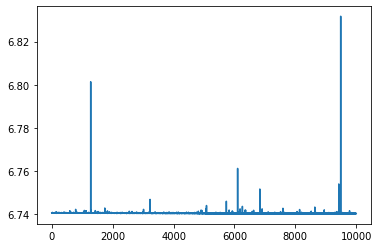

In [15]:
mod1.plot_history(total_iterations - 10000)

We see that the loss is constant in the last 10000 iterations. Overall, this suggests the optimization has really converged.

Now that we fit the model to our data we can get a new count matrix that is corrected for background and sampling noise. To approximate this corrected count matrix we take 1000 samples from the posterior distribution of the model:

In [16]:
mod1.sample_posterior(node='all', n_samples=1000, save_samples=False);

And then compute "X_corrected" as A_gr in the model description above:

In [17]:
ProbeCounts_GeneralModel_V1.compute_X_corrected(mod1)

In [18]:
mod1.X_naive

array([[ 16.,   0., 115., ..., 148.,  56.,  41.],
       [  1.,  34.,  95., ..., 192., 101.,  92.],
       [ 10.,  27., 150., ..., 197.,  77.,  80.],
       ...,
       [  8.,  25.,  39., ...,  78.,  39.,  29.],
       [ 12.,  45.,  57., ..., 145.,  73.,  59.],
       [  0.,   9.,   0., ...,  42.,  33.,  24.]], dtype=float32)

Importantly the X_corrected values are probability distributions, so we can look both at the mean:

In [19]:
print('mean', mod1.X_corrected_mean)

mean [[ 52.  44. 172. ...  89.  55.  28.]
 [ 51.  91. 145. ...  82.  55.  29.]
 [ 39.  51. 125. ... 108.  45.  26.]
 ...
 [ 21.  36.  49. ...  33.  23.  12.]
 [ 42.  76. 102. ...  52.  44.  21.]
 [ 14.  20.  30. ...  23.  16.   9.]]


And their 90% confidence interval:

In [20]:
print('q05', mod1.X_corrected_q05)
print('q95', mod1.X_corrected_q95)

q05 [[ 44.  36. 160. ...  77.  46.  19.]
 [ 45.  84. 136. ...  73.  48.  21.]
 [ 33.  44. 117. ...  99.  39.  19.]
 ...
 [ 18.  33.  46. ...  29.  20.   9.]
 [ 37.  71.  96. ...  45.  38.  16.]
 [ 12.  18.  28. ...  19.  13.   6.]]
q95 [[ 61.  54. 184. ... 103.  67.  38.]
 [ 58.  99. 155. ...  93.  64.  37.]
 [ 45.  59. 134. ... 118.  53.  34.]
 ...
 [ 24.  39.  52. ...  37.  26.  16.]
 [ 47.  82. 109. ...  59.  51.  27.]
 [ 17.  24.  33. ...  27.  21.  13.]]


We have a plotting function to produce a simple overview of the model behaviour and to compare it to a "naive" model that simply calculates the mean number of negative probe counts in each ROI and subtracts this number from each gene:

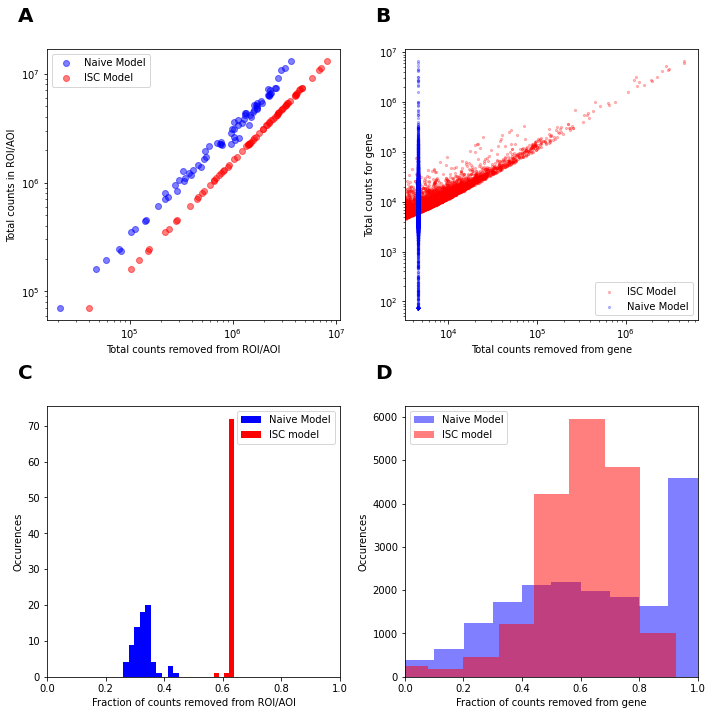

In [21]:
mod1.plot_X_corrected_overview2()

Also make the plot D alone without the Naive model:

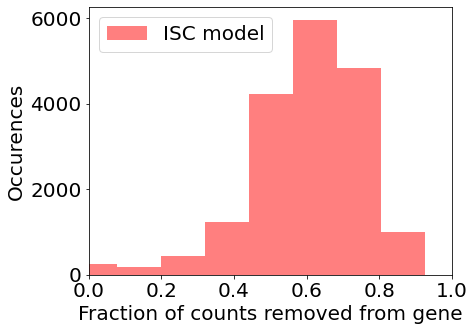

In [22]:
import imp
import isctools
from isctools import pymc3_model
imp.reload(isctools.pymc3_model)
imp.reload(isctools.ProbeCounts__GeneralModel_V1)
from isctools.ProbeCounts__GeneralModel_V1 import ProbeCounts_GeneralModel_V1
ProbeCounts_GeneralModel_V1.plot_X_corrected_overview3(mod1, saveFig = 'Figure2C_FractionRemoved.pdf')

In figure A we see in red that our model expects the number of background counts to scale linearly with the total number of counts in an ROI/AOI. This agrees with the negative probe data, where the mean counts of negative probes scale linearly with the total gene probe counts as shown in blue. If there were some blue dots that strongly deviate from this linear relationship this would suggest some ROIs/AOIs with particularly high background which our model does not account for, but in this dataset we do not see any of this. In addition, we see that our model removes more background counts than would be expected from the average negative probe counts. This could be because of some outlier probes the model identifies with an extremely high background. Figure C makes the same point, but shown as a historgram of the fraction of removed counts from each ROI/AOIs. The width of the blue distribution, thus shows to what extent it fits a linear relationship and the difference between the blue and red distribution, shows how much more counts our model removes compared to the expectation from negative probe counts alone.

In figure B we see one of the main difference between our model and the naive approach. If we just remove the mean negative probe count from each gene then we assume a constant background for each gene, as shown by the vertical blue line. In contrast to this, our model calculates a gene specific measurment noise, as shown in red. This shows that many genes are predicted to have less background than the mean negative probe counts, but many genes are also far above the mean negative probe count. Figure D shows the distribution of the fraction of counts removed from each gene. A problem with our current approach could be that the model never removes 100% of the counts.

If only one overview function for the model behaviour is desired this figure is a good summary:

In [75]:
def plot_X_corrected_overview4(self, genesOfInterest, cmap = 'cool', saveFig = None):

    r""" Plots a scatter plot of removed counts vs. total counts for each gene probe, colour by fraction removed. 
    In addition, includes a line for the naive model """

    total_counts_gene = np.sum(self.X_data, axis = 0)
    removed_counts_ISC_gene = np.sum(self.X_data, axis = 0) -  np.sum(self.X_corrected_mean, axis = 0)
    fraction_removed = removed_counts_ISC_gene/total_counts_gene
    removed_counts_Naive = np.repeat(np.sum(np.mean(self.Y_data, axis = 0)), np.shape(self.X_data)[1])

    subset = fraction_removed > 0

    removed_counts_ISC_gene = removed_counts_ISC_gene[subset]
    total_counts_gene = total_counts_gene[subset]
    fraction_removed = fraction_removed[subset]
    removed_counts_Naive = removed_counts_Naive[subset]

    geneIndex_to_annotate = np.squeeze([np.where(self.var_names[subset] == genesOfInterest[i])
                                    for i in range(len(genesOfInterest))])

    SMALL_SIZE = 26
    MEDIUM_SIZE = 26
    BIGGER_SIZE = 26
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    fig, ax = plt.subplots(1,1, figsize=(15,10))

    mesh = ax.scatter(total_counts_gene,  removed_counts_ISC_gene, alpha = 0.5, c = fraction_removed, label = 'ISC Model',
       s=10, cmap = cmap)
    ax.scatter(total_counts_gene, removed_counts_Naive, c = 'black', label = 'Naive Model')
    ax.legend()
    ax.set_xlabel('Total counts for gene')
    ax.set_ylabel('Total counts removed from gene')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(10, 10**7)
    ax=plt.gca()
    cbar = fig.colorbar(mesh)
    cbar.set_label('Fraction Removed')

    ts = []    
    for i,j in enumerate(geneIndex_to_annotate):
        ts.append(plt.text(total_counts_gene[j],  removed_counts_ISC_gene[j], genesOfInterest[i]))
    adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), force_text = 2.5,
           force_points = 2.5, force_objects = 2.5)

    if saveFig:
        plt.savefig(saveFig)

    plt.show()

In [76]:
self = mod1
total_counts_gene = np.sum(self.X_data, axis = 0)
removed_counts_ISC_gene = np.sum(self.X_data, axis = 0) -  np.sum(self.X_corrected_mean, axis = 0)
fraction_removed = removed_counts_ISC_gene/total_counts_gene
removed_counts_Naive = np.repeat(np.sum(np.mean(self.Y_data, axis = 0)), np.shape(self.X_data)[1])

In [77]:
np.shape(total_counts_gene)

(18317,)

In [99]:
np.where(adata_wta.obs['VCDepth'] > 0.9)

(array([21, 27, 35, 41]),)

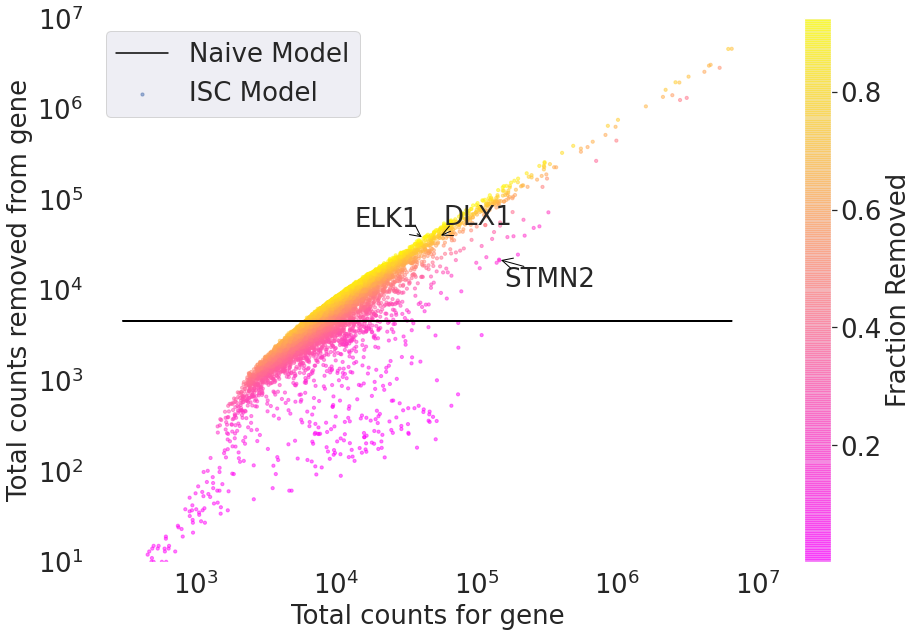

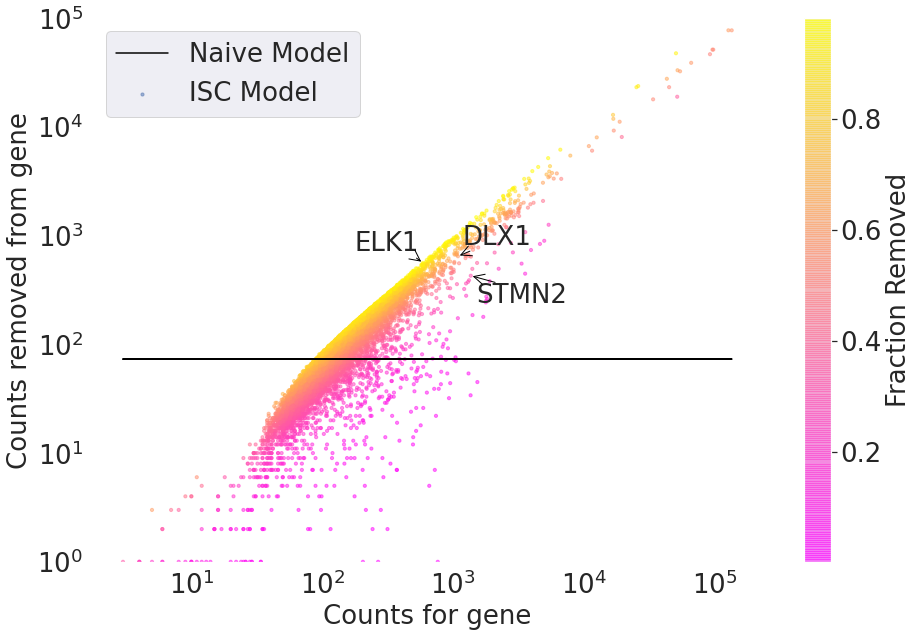

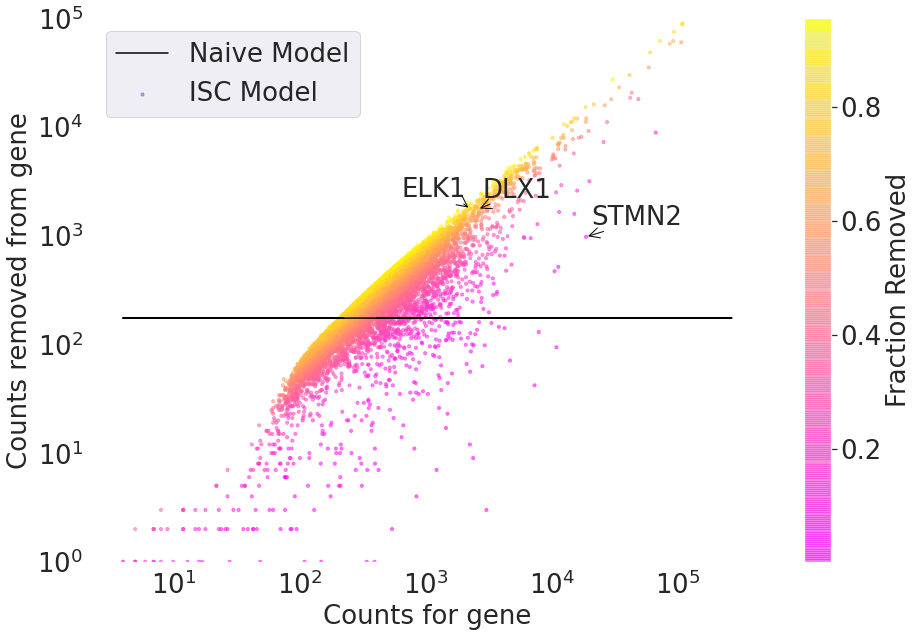

In [108]:
import imp
import isctools
from isctools import pymc3_model
imp.reload(isctools.pymc3_model)
imp.reload(isctools.ProbeCounts__GeneralModel_V1)
from isctools.ProbeCounts__GeneralModel_V1 import ProbeCounts_GeneralModel_V1

genesOfInterest = np.array(('DLX1', 'STMN2', 'ELK1'))

ProbeCounts_GeneralModel_V1.plot_X_corrected_overview4(mod1, genesOfInterest, cmap = 'spring', saveFig = 'Figure2B_ModelOverview_Cmap-summer_Draft2_19pcw1_AllROIs_whiteBackground.pdf')
ProbeCounts_GeneralModel_V1.plot_X_corrected_overview_OneROI(mod1, genesOfInterest, 2, cmap = 'spring', saveFig = 'Figure2B_ModelOverview_Cmap-summer_Draft2_OneROI_VZ_whiteBackground.pdf')
ProbeCounts_GeneralModel_V1.plot_X_corrected_overview_OneROI(mod1, genesOfInterest, 21, cmap = 'spring', saveFig = 'Figure2B_ModelOverview_Cmap-summer_Draft2_OneROI_CP_whiteBackground.pdf')

We can also rank genes by what percentage of counts were removed from them:

In [79]:
rankedGenes = mod1.rank_X_corrected_genes()
rankedGenes

,Gene,Total Counts,Removed Counts,Fraction Removed Counts (Mean),Fraction Removed Counts (q05),Fraction Removed Counts (q95)
ATRX,ATRX,58749,54314,0.924509,0.940390,0.904169
CFDP1,CFDP1,37584,34387,0.914937,0.934706,0.888889
ZNF782,ZNF782,38726,35371,0.913366,0.934153,0.886588
OBP2A,OBP2A,24213,22043,0.910379,0.935861,0.875315
DLST,DLST,26617,24156,0.907540,0.932675,0.875268
...,...,...,...,...,...,...
CEBPD,CEBPD,74,-21,-0.283784,0.243243,-1.162162
SNX14,SNX14,74,-21,-0.283784,0.243243,-1.135135
"NXF2B,NXF2","NXF2B,NXF2",74,-21,-0.283784,0.229730,-1.175676
EIF4EBP1,EIF4EBP1,74,-21,-0.283784,0.243243,-1.175676


In [25]:
rankedGenes.iloc[1:60]

,Gene,Total Counts,Removed Counts,Fraction Removed Counts (Mean),Fraction Removed Counts (q05),Fraction Removed Counts (q95)
CFDP1,CFDP1,37584,34387,0.914937,0.934706,0.888889
ZNF782,ZNF782,38726,35371,0.913366,0.934153,0.886588
OBP2A,OBP2A,24213,22043,0.910379,0.935861,0.875315
DLST,DLST,26617,24156,0.907540,0.932675,0.875268
HSPB8,HSPB8,94626,85863,0.907393,0.919937,0.891890
EPC1,EPC1,45110,40770,0.903791,0.921836,0.880935
ZNF37A,ZNF37A,84387,76067,0.901407,0.915259,0.884923
ZNF768,ZNF768,22028,19778,0.897857,0.925912,0.861313
ZNF684,ZNF684,44142,39597,0.897037,0.916678,0.872366
PRRC2B,PRRC2B,42910,38443,0.895898,0.916034,0.870986


Let's gather the top 3 genes with most removed counts and put them in a list with a few well known cell type markers. Then let's look up this list of genes in the scRNAseq study by Polioudakis et al., Neuron 2019, to check how cell types in the fetal brain express those genes:

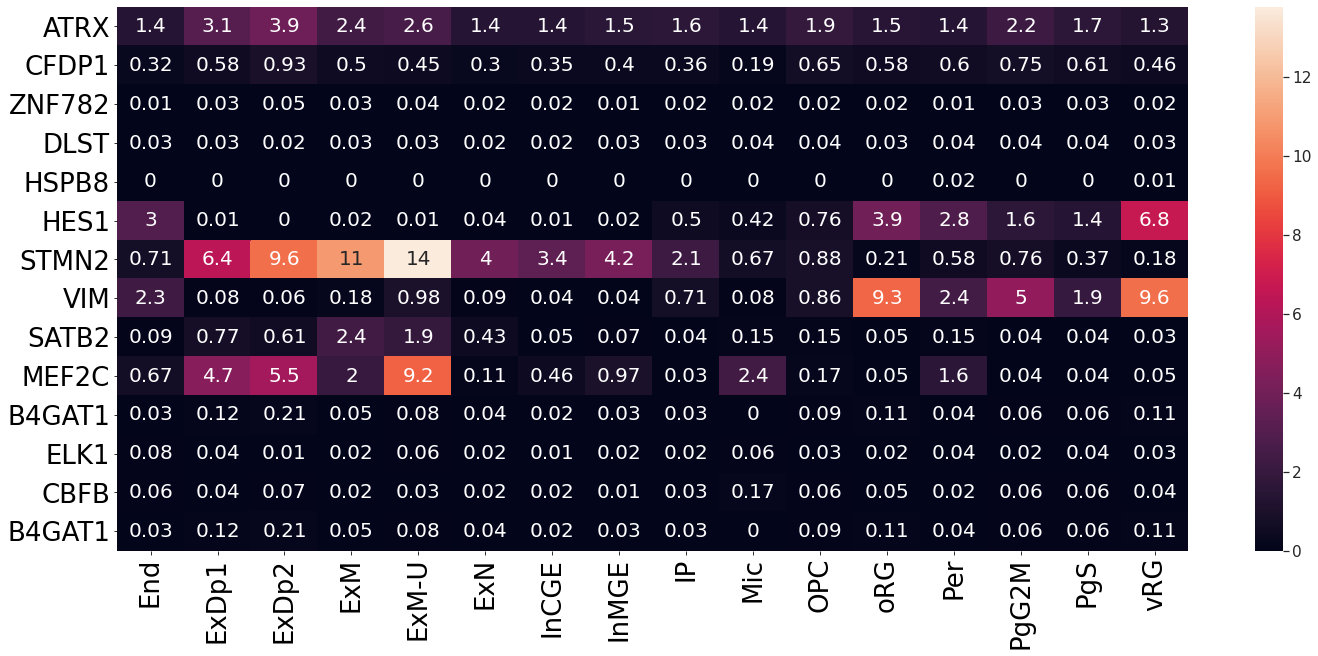

In [26]:
# Get reference scRNAseq data:
meanExpression_sc = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)

# Make our gene list:
commonGenes = [rankedGenes['Gene'].iloc[i] for i in range(len(rankedGenes)) if rankedGenes['Gene'].iloc[i] in meanExpression_sc.index]
topGenes = commonGenes[0:5]
celltypeMarkers = np.array(('HES1', 'STMN2','VIM', 'SATB2', 'MEF2C', 'B4GAT1', 'ELK1', 'CBFB', 'B4GAT1'))
lookup_genes = np.concatenate([topGenes, celltypeMarkers])

# Plot cell type specific expression of genes:
fig, ax = plt.subplots(figsize=(24,10))
sns.set(font_scale=1.4)
sns.heatmap(np.round(meanExpression_sc.loc[lookup_genes,:],2), annot = True,  annot_kws={"size": 20})

Excluding ATRX, the genes with many removed counts are not supposed to be expressed in the fetal brain at a high level at all, yet they have more total counts than some of our cell type markers, which we can see by inspecting the rankedGenes dataframe:

In [27]:
rankedGenes.loc[[rankedGenes['Gene'].iloc[i] in lookup_genes for i in range(len(rankedGenes['Gene']))],:]

,Gene,Total Counts,Removed Counts,Fraction Removed Counts (Mean),Fraction Removed Counts (q05),Fraction Removed Counts (q95)
ATRX,ATRX,58749,54314,0.924509,0.940390,0.904169
CFDP1,CFDP1,37584,34387,0.914937,0.934706,0.888889
ZNF782,ZNF782,38726,35371,0.913366,0.934153,0.886588
DLST,DLST,26617,24156,0.907540,0.932675,0.875268
HSPB8,HSPB8,94626,85863,0.907393,0.919937,0.891890
ELK1,ELK1,41939,37080,0.884141,0.904623,0.858890
CBFB,CBFB,6557375,4597265,0.701083,0.707996,0.692576
B4GAT1,B4GAT1,12331,8378,0.679426,0.722975,0.627362
HES1,HES1,12087,4542,0.375776,0.421693,0.323405
STMN2,STMN2,144820,21674,0.149662,0.163845,0.134595


Hence the model likely correctly identified faulty probes with an excessive number of non-specific binding events.

One weakness of the current model seems to be that it never identifies 100% of the counts as measurement noise (one of the disadvantages of non-negative matrix factorization used for A_rg in the model is that values don't tend to go to 0). Hence, all genes still have at least 1 count. To determine, which genes are detected in a given ROI/AOI, we thus need to choose an arbitrary cutoff, which we choose at 50 counts for now. This roughly matches the number of detected genes we get by using the limit of detection provided by the Nanostring software, as shown in the following plot, that illustrates the number of detected genes per ROI across cortical depth:

In [28]:
absolute_cutoff = 50
ProbeCounts_GeneralModel_V1.compute_X_detected(mod1, absolute_cutoff)
print('X_detected', mod1.X_detected)

X_detected [[0 0 1 ... 1 0 0]
 [0 1 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [29]:
x = np.asarray(adata_wta.obs['VCDepth'])
order = np.where([adata_wta.obs['Radial_position'][i] == 2 for i in range(len(adata_wta.obs['Radial_position']))])[0]
nuclei = np.asarray(adata_wta.obs['nuclei'])
LoD_cutoff = adata_wta.obs['GeoLOD2.5_01']

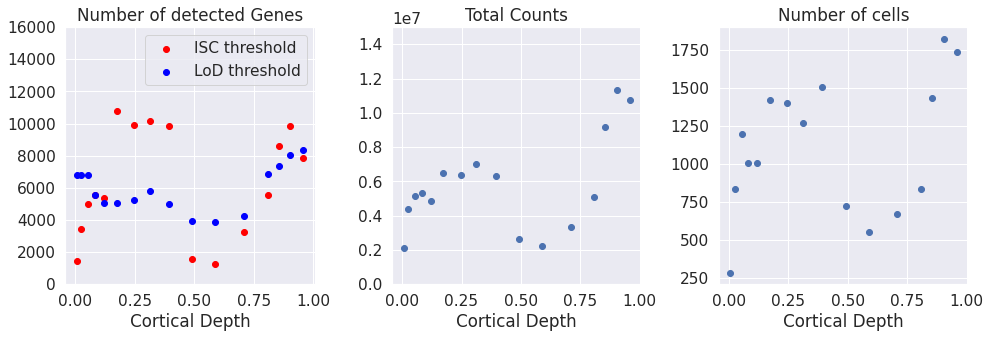

In [30]:
import imp
import isctools
from isctools import pymc3_model
imp.reload(isctools.pymc3_model)
imp.reload(isctools.ProbeCounts__GeneralModel_V1)
from isctools.ProbeCounts__GeneralModel_V1 import ProbeCounts_GeneralModel_V1
ProbeCounts_GeneralModel_V1.plot_X_detected(mod1, x, order, nuclei, LoD_cutoff, xlabel = 'Cortical Depth', saveFig = 'DetectedGenes.pdf')

Finally, let's plot a comparison of our corrected and cpm normalized counts (ISC-CPM) and uncorrected standard counts-per-million (CPM) for a list of chosen genes. This list contains ATRX, plus other genes that are differentially expressed in certain fetal brain cell types (again taken from the Polioudakis et al. Neuron 2019 study), as shown in the heatmap:

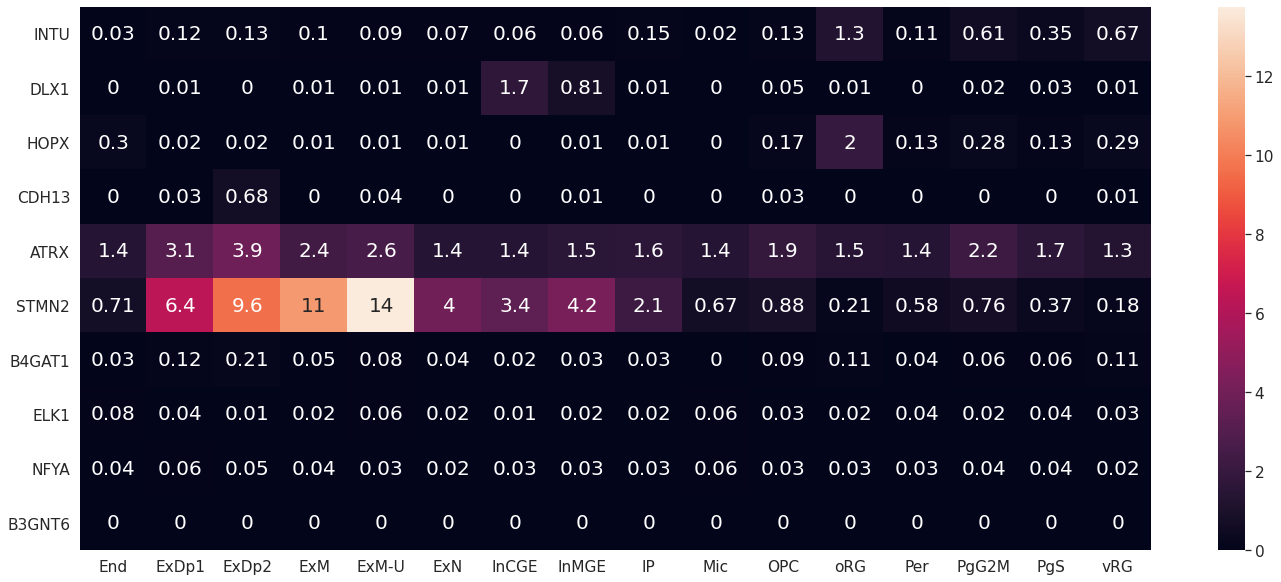

In [31]:
# example_genes = np.array(('INTU', 'DLX1', 'HOPX', 'CDH13', 'ATRX', 'STMN2', 'B4GAT1',  'ELK1'))
example_genes = np.array(('INTU', 'DLX1', 'HOPX', 'CDH13', 'ATRX', 'STMN2', 'B4GAT1', 'ELK1', 'NFYA', 'B3GNT6'))
# Plot cell type specific expression of genes:
fig, ax = plt.subplots(figsize=(24,10))
sns.set(font_scale=1.4)
sns.heatmap(np.round(meanExpression_sc.loc[example_genes,:],2), annot = True,  annot_kws={"size": 20})

Find genes with low scRNAseq expression, but high expression in WTA, as well as high fraction of counts removed:

In [32]:
from scipy.stats import rankdata
commonGenes = [g for g in rankedGenes['Gene'] if g in meanExpression_sc.index]
meanExpression_sc = meanExpression_sc.reindex(index = commonGenes)
rankedGenes = rankedGenes.iloc[[np.where(rankedGenes['Gene'] == g)[0][0] for g in commonGenes if g in rankedGenes['Gene']]]
rank1 = rankdata(np.sum(meanExpression_sc, axis = 1))
rank2 = rankdata(-rankedGenes['Fraction Removed Counts (Mean)'])
bestGenes = np.array(commonGenes)[np.argsort(rank1**2*rank2)]

,Gene,Total Counts,Removed Counts,Fraction Removed Counts (Mean),Fraction Removed Counts (q05),Fraction Removed Counts (q95)
ATRX,ATRX,58749,54314,0.924509,0.940390,0.904169
ELK1,ELK1,41939,37080,0.884141,0.904623,0.858890
NFYA,NFYA,153864,135796,0.882572,0.893705,0.869690
B3GNT6,B3GNT6,79811,68625,0.859844,0.875594,0.842478
CDH13,CDH13,17589,12935,0.735403,0.772642,0.691398
DLX1,DLX1,54218,39163,0.722325,0.740787,0.700727
B4GAT1,B4GAT1,12331,8378,0.679426,0.722975,0.627362
INTU,INTU,12809,7906,0.617222,0.658834,0.568272
HOPX,HOPX,12316,6972,0.566093,0.607015,0.516401
STMN2,STMN2,144820,21674,0.149662,0.163845,0.134595


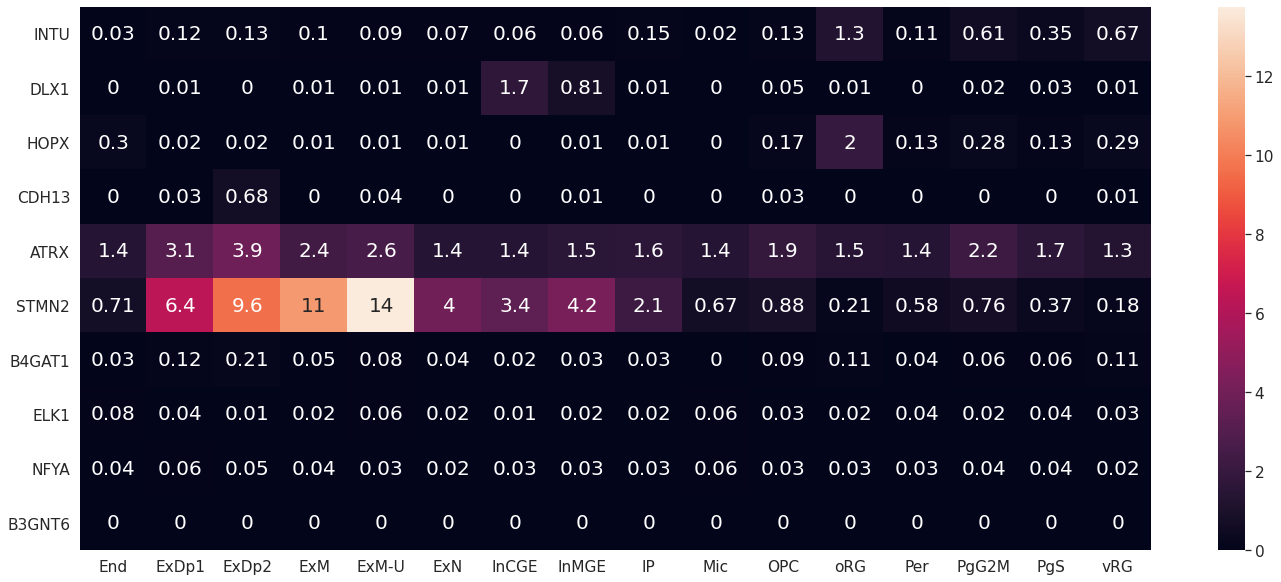

In [33]:
example_genes = np.array(('INTU', 'DLX1', 'HOPX', 'CDH13', 'ATRX', 'STMN2', 'B4GAT1',  'ELK1', 'NFYA', 'B3GNT6'))
#example_genes = bestGenes[:300]
# Plot cell type specific expression of genes:
fig, ax = plt.subplots(figsize=(24,10))
sns.set(font_scale=1.4)
sns.heatmap(np.round(meanExpression_sc.loc[example_genes,:],2), annot = True,  annot_kws={"size": 20})
rankedGenes.loc[[rankedGenes['Gene'].iloc[i] in example_genes for i in range(len(rankedGenes['Gene']))],:]

And this is their expression across cortical depth as counts per million, both corrected (ISC-CPM) and uncorrected (CPM):

In [34]:
x = np.asarray(adata_wta.obs['VCDepth'])
order = np.where([adata_wta.obs['Radial_position'][i] == 2 for i in range(len(adata_wta.obs['Radial_position']))])[0]

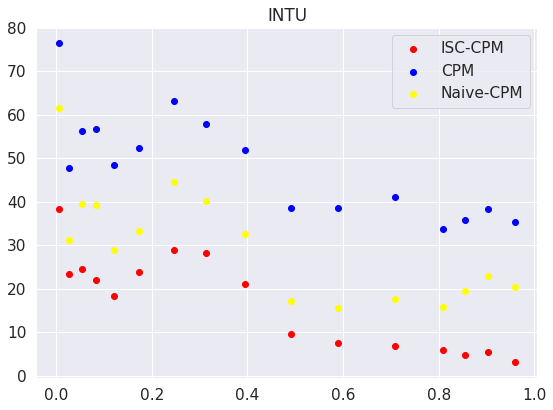

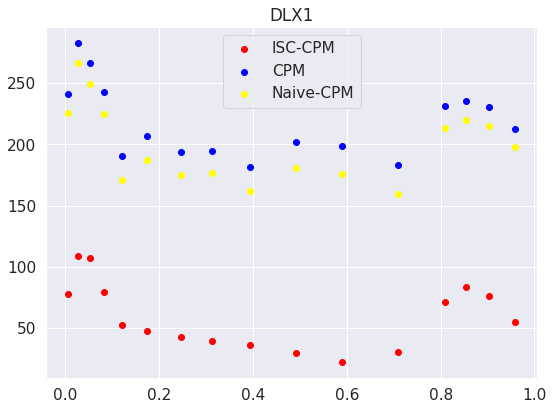

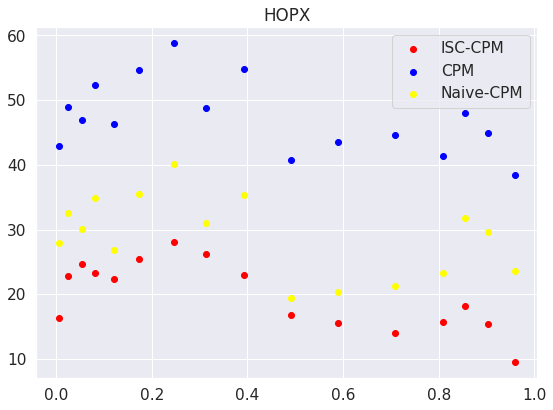

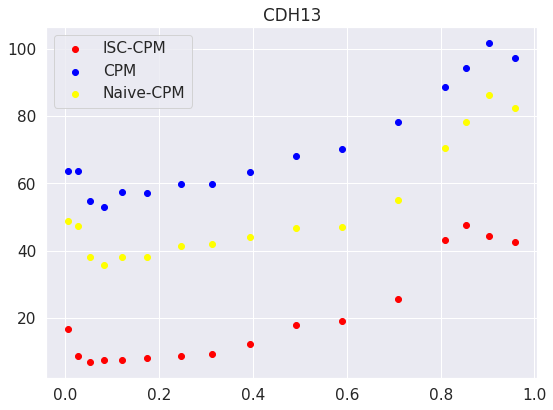

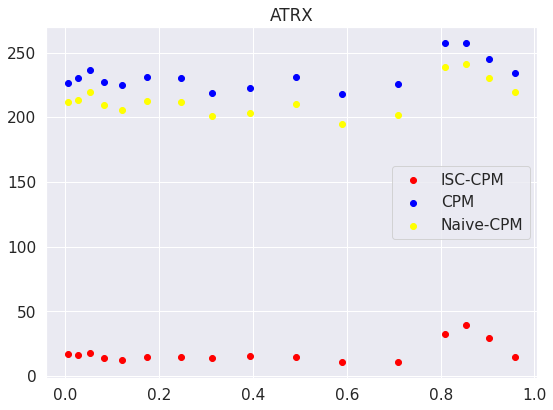

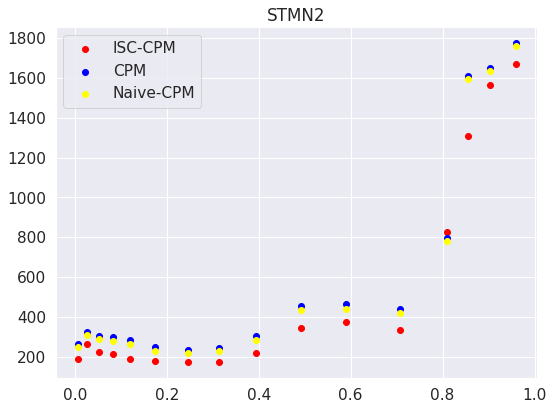

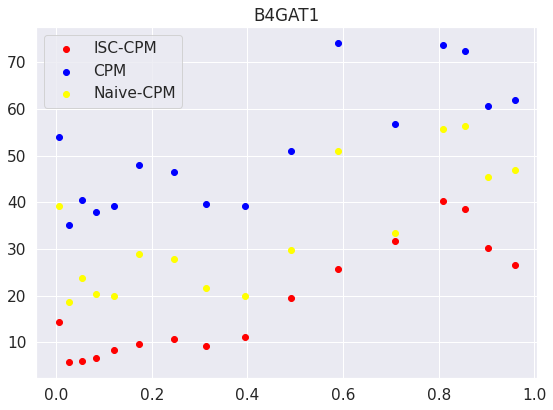

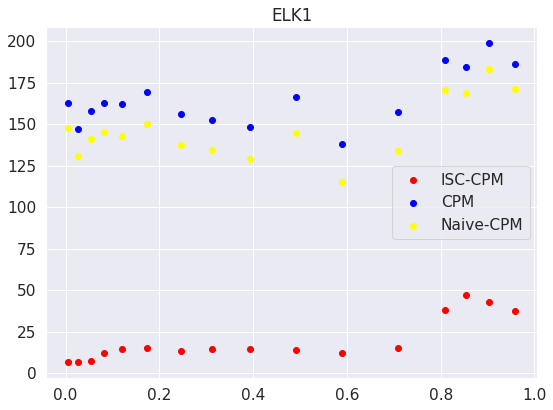

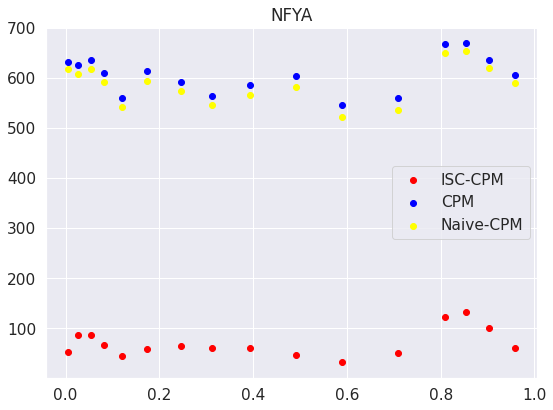

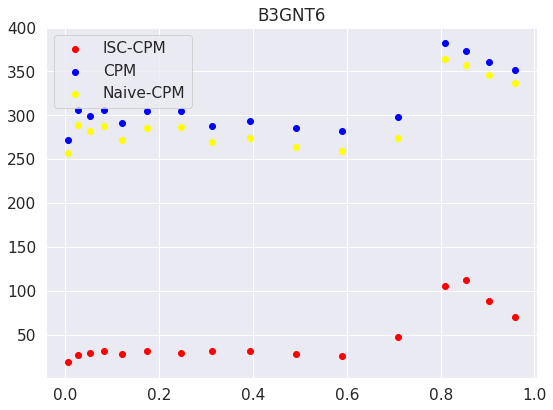

In [35]:
import imp
import isctools
from isctools import pymc3_model
imp.reload(isctools.pymc3_model)
imp.reload(isctools.ProbeCounts__GeneralModel_V1)
from isctools.ProbeCounts__GeneralModel_V1 import ProbeCounts_GeneralModel_V1
ProbeCounts_GeneralModel_V1.plot_X_corrected_exampleGenes1(mod1, x, order, example_genes, saveFig = 'ExampleGenes.pdf', naiveModel = True)

Clearly, the corrected counts (ISC-CPM) make a lot of sense, since they result in high expression at cortical depths, where we would expect the cell type they mark to be located. For example, INTU is particularly highly expressed in vRGs and oRGs, which are found at lower cortical depth and CDH13 is particulary highly expressed in deep layer excitatory neurons, which are found at higher cortical depth. Finally ATRX is expressed in most cell types, but most highly in deep layer excitatory neurons, which is exactly where the expression peaks on the plot.

Furthermore we can compare downstream analysis results between using ISC-CPM and standard CPM. For example doing a standard Wilcoxon rank sum test with the diffxpy python package to find differentially expressed genes between HOPX positive and EOMES positive cell type specific AOIs:

In [36]:
# Get our HOPXpos and EOMESpos AOIs:
order_HOPX = np.where([adata_wta.obs['AOI_type'][i] == 'HOPXpos' for i in range(len(adata_wta.obs['Radial_position']))])[0]
order_EOMES = np.where([adata_wta.obs['AOI_type'][i] == 'EOMESpos' for i in range(len(adata_wta.obs['Radial_position']))])[0]
order = np.concatenate([order_HOPX, order_EOMES])

# Get cpm for both corrected (isc_cpm) and uncorrected data (cpm):
total_counts = np.sum(mod1.X_data, axis = 1)
cpm = mod1.X_data/total_counts.reshape(np.shape(mod1.X_data)[0],1)*10**6
isc_cpm = mod1.X_corrected_mean/total_counts.reshape(np.shape(mod1.X_data)[0],1)*10**6

# Put data into two AnnData objects:
adata_cpm = adata = sc.AnnData(X=cpm[order],
                               obs=pd.DataFrame(data = np.concatenate([np.repeat('HOPXpos', len(order_HOPX)),
                                                                      np.repeat('EOMESpos', len(order_EOMES))]),
                                                columns = ['Cell Type']))

adata_isc_cpm = adata = sc.AnnData(X=isc_cpm[order],
                               obs=pd.DataFrame(data = np.concatenate([np.repeat('HOPXpos', len(order_HOPX)),
                                                                      np.repeat('EOMESpos', len(order_EOMES))]),
                                                columns = ['Cell Type']))

# Perform differential expression with diffxpy for both cases:

test_rank_cpm = de.test.rank_test(
    data=adata_cpm,
    grouping="Cell Type",
    gene_names = mod1.var_names,
    ).summary()

test_rank_isc_cpm = de.test.rank_test(
    data=adata_isc_cpm,
    grouping="Cell Type",
    gene_names = mod1.var_names,
    ).summary()


Transforming to str index.
Transforming to str index.


Without correction we have 195 genes with an (absolute) log2FC > 1 and q-value < 0.05, but with correction we get 1227:

In [37]:
threshold = 1

In [38]:
cpm_genes = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['qval'][i] < 0.05 and abs(test_rank_cpm['log2fc'][i]) > threshold for i in range(len(test_rank_cpm['qval']))]])
isc_cpm_genes = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['qval'][i] < 0.05 and abs(test_rank_isc_cpm['log2fc'][i]) > threshold for i in range(len(test_rank_cpm['qval']))]])

print(len(cpm_genes))
print(len(isc_cpm_genes))

198
1282


If we do not have a log2FC cutoff the difference becomes even larger:

In [39]:
cpm_genes = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['qval'][i] < 0.05 for i in range(len(test_rank_cpm['qval']))]])
isc_cpm_genes = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['qval'][i] < 0.05 for i in range(len(test_rank_cpm['qval']))]])

print(len(cpm_genes))
print(len(isc_cpm_genes))

865
10044


But are these additional genes biologically sensible? To check for this we can compare them to differentially expressed genes between IPs and oRGs in our reference scRNAseq study (Polioudakis et al., Neuron 2019). We load Wilcoxon rank sum test results for cpm normalized data from this study here:

In [40]:
sc_de_results = pickle.load(open(path + 'data/oRG_IP_Polioudakis2019_DE_cpm_results.p', "rb"))

Next we split genes into three groups, depending on whether they are differentially expressed with a log2FC > 1 for oRG, IP or not differentially expressed.

In [41]:
group1_cpm = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['qval'][i] < 0.05 and test_rank_cpm['log2fc'][i] > threshold for i in range(len(test_rank_cpm['qval']))]])
group2_cpm = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['qval'][i] < 0.05 and test_rank_cpm['log2fc'][i] < -threshold for i in range(len(test_rank_cpm['qval']))]])
negatives_cpm = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['gene'][i] not in group1_cpm and test_rank_cpm['gene'][i] not in group2_cpm for i in range(len(test_rank_cpm['gene']))]])
                                    
group1_isc_cpm = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['qval'][i] < 0.05 and test_rank_isc_cpm['log2fc'][i] > threshold for i in range(len(test_rank_isc_cpm['qval']))]])
group2_isc_cpm = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['qval'][i] < 0.05 and test_rank_isc_cpm['log2fc'][i] < -threshold for i in range(len(test_rank_isc_cpm['qval']))]])
negatives_isc_cpm = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['gene'][i] not in group1_cpm and test_rank_isc_cpm['gene'][i] not in group2_cpm for i in range(len(test_rank_isc_cpm['gene']))]])

group1_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['qval'][i] < 0.05 and sc_de_results['log2fc'][i] > threshold for i in range(len(sc_de_results['log2fc']))]])
group2_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['qval'][i] < 0.05 and sc_de_results['log2fc'][i] < -threshold for i in range(len(sc_de_results['log2fc']))]])
negatives_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['gene'][i] not in group1_reference and sc_de_results['gene'][i] not in group2_reference for i in range(len(sc_de_results['gene']))]])


Then we use a simple function to calculate precision and recall and f-score (the geometric mean of the two) based on these groups:

In [42]:
def evaluatePerformance(group1, group2, negatives, group1_reference, group2_reference, negatives_reference):
    
    # Reduce to common genes:
    test_genes = np.concatenate([group1, group2, negatives])
    reference_genes = np.concatenate([group1_reference, group2_reference, negatives_reference])
    common_genes = reference_genes[[reference_genes[i] in test_genes for i in range(len(reference_genes))]]
    
    group1 = group1[[group1[i] in common_genes for i in range(len(group1))]]
    group2 = group2[[group2[i] in common_genes for i in range(len(group2))]]
    negatives = negatives[[negatives[i] in common_genes for i in range(len(negatives))]]
    
    group1_reference = group1_reference[[group1_reference[i] in common_genes for i in range(len(group1_reference))]]
    group2_reference = group2_reference[[group2_reference[i] in common_genes for i in range(len(group2_reference))]]
    negatives_reference = negatives_reference[[negatives_reference[i] in common_genes for i in range(len(negatives_reference))]]
    
    # Calculate recall, precision and f-score:
    recall = (sum([group1[i] in group1_reference for i in range(len(group1))]) +
    sum([group2[i] in group2_reference for i in range(len(group2))]))/(len(group1_reference) + len(group2_reference)) 
                                                                       
    precision = (sum([group1[i] in group1_reference for i in range(len(group1))])+
                 sum([group2[i] in group2_reference for i in range(len(group2))]))/(len(group1) + len(group2))   
                                                                       
    fscore = 2*(precision*recall)/(precision+recall)
    
    return np.array((fscore, precision, recall))

In [43]:
evaluatePerformance(group1_cpm, group2_cpm, negatives_cpm, group1_reference, group2_reference, negatives_reference)

array([0.09111918, 0.95833333, 0.04783362])

In [44]:
evaluatePerformance(group1_isc_cpm, group2_isc_cpm, negatives_isc_cpm, group1_reference, group2_reference, negatives_reference)

array([0.27277252, 0.48281938, 0.19007978])

Hence, using the corrected counts increase recall from 0.05 to 0.2 and increases the f-score from 0.1 to 0.29 and thus overall improves differential expression performance.

Finally, using the X_corrected_mean matrix in the downstream analysis actually disregards a lot of uncertainty that remains about the magnitude of the measurement noise. To circumvent this problem, we also have a differential expression method that directly works with the full model posterior distribution and computes the average log2FC and associated uncertainty across a set of chosen ROIs/AOIs:

In [45]:
mod1.compute_logFC(groupA = order_HOPX, groupB = order_EOMES)

In [46]:
mod1.compute_FDR(logFC_threshold = threshold)

In [47]:
mod1.logFC

,groupA,groupB,mean,sd,q05,q95,threshold,probability,FDR
TMEM132B,"16, 17, 18, 42, 43, 44, 64, 65, 66, 67","9, 10, 11, 36, 37, 38, 58, 59, 60, 61",2.344632,0.090489,2.192679,2.497147,1,1.0,0.000000
SEPTIN9,"16, 17, 18, 42, 43, 44, 64, 65, 66, 67","9, 10, 11, 36, 37, 38, 58, 59, 60, 61",1.697576,0.077162,1.566216,1.824254,1,1.0,0.000000
H2AC13,"16, 17, 18, 42, 43, 44, 64, 65, 66, 67","9, 10, 11, 36, 37, 38, 58, 59, 60, 61",-1.256352,0.025384,-1.286328,-1.208274,1,1.0,0.000000
H2AC14,"16, 17, 18, 42, 43, 44, 64, 65, 66, 67","9, 10, 11, 36, 37, 38, 58, 59, 60, 61",-1.310882,0.010416,-1.323030,-1.293362,1,1.0,0.000000
H2AC16,"16, 17, 18, 42, 43, 44, 64, 65, 66, 67","9, 10, 11, 36, 37, 38, 58, 59, 60, 61",-1.220429,0.033225,-1.260558,-1.158924,1,1.0,0.000000
...,...,...,...,...,...,...,...,...,...
PIK3R1,"16, 17, 18, 42, 43, 44, 64, 65, 66, 67","9, 10, 11, 36, 37, 38, 58, 59, 60, 61",-0.307689,0.217415,-0.569256,0.116348,1,0.0,0.925187
PIK3R5,"16, 17, 18, 42, 43, 44, 64, 65, 66, 67","9, 10, 11, 36, 37, 38, 58, 59, 60, 61",-0.348519,0.213045,-0.650750,0.039088,1,0.0,0.925187
ERICH4,"16, 17, 18, 42, 43, 44, 64, 65, 66, 67","9, 10, 11, 36, 37, 38, 58, 59, 60, 61",-0.431248,0.229357,-0.746231,0.003782,1,0.0,0.925187
PISD,"16, 17, 18, 42, 43, 44, 64, 65, 66, 67","9, 10, 11, 36, 37, 38, 58, 59, 60, 61",-0.365826,0.206846,-0.633878,0.001720,1,0.0,0.925187


Surprisingly, with an f-score of 0.27 this approach does not perform quite as well as applying a Wilcoxon rank-sum test on the X_corrected_mean matrix (which had an f-score of 0.29):

In [48]:
group1_isc_full = np.asarray(mod1.logFC.index[[mod1.logFC['FDR'].iloc[i] < 0.05 and mod1.logFC['mean'][i] > threshold for i in range(len(mod1.logFC['mean']))]])
group2_isc_full = np.asarray(mod1.logFC.index[[mod1.logFC['FDR'].iloc[i] < 0.05 and mod1.logFC['mean'][i] < -threshold for i in range(len(mod1.logFC['mean']))]])
negatives_isc_full = np.asarray(mod1.logFC.index[[mod1.logFC.index[i] not in group1_isc_full and mod1.logFC.index[i] not in group2_isc_full for i in range(len(mod1.logFC.index))]])

In [49]:
evaluatePerformance(group1_isc_full, group2_isc_full, negatives_isc_full, group1_reference, group2_reference, negatives_reference)

array([0.24011065, 0.59452055, 0.15043328])

However, the difference is small. In addition, our benchmark is far from perfect for multiple reasons. Firstly, there may be differences between scRNAseq and in-situ transcriptomic data, as well as between different brain regions. Furthermore, we used the same test (Wilcoxon rank sum) to establish our benchmark, hence this can bias the results towards using the Wilcoxon rank sum test alone. Finally, there may be differences in the data resulting from imperfect image segmentation that selected parts of other cell types in addition to HOPX positive and EOMES positives cells. So overall, we recommend using both approaches for differential expression for now.

In [50]:
import imp
import isctools
from isctools import pymc3_model
imp.reload(isctools.pymc3_model)
imp.reload(isctools.ProbeCounts__GeneralModel_V1)
from isctools.ProbeCounts__GeneralModel_V1 import ProbeCounts_GeneralModel_V1

In [51]:
sum(mod1.logFC['FDR'] < 0.05)

846

In [52]:
np.shape(meanExpression_sc)

(15163, 16)